In [2]:
pip install --upgrade jinja2

Note: you may need to restart the kernel to use updated packages.


In [24]:
from PairsTradingKalmanFilter import *
from PairsTradingBacktest import *
from IPython.display import display, HTML
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [25]:
df_prices_test = pd.read_csv("data/etfs/df_prices_test.csv", index_col=0)
df_prices_test.index = pd.to_datetime(df_prices_test.index)
prices = df_prices_test

index = prices.index.strftime('%Y-%m-%d')
# S&P500 ETF
# sp500 = yf.download('SPY', start=index[0], end=index[-1])['Adj Close']
sp500 = yf.download('^GSPC', start=index[0], end=index[-1])['Adj Close']
sp500_nav = sp500 / sp500.iloc[0]
sp500_drawdowns = calculate_drawdown(sp500_nav)

# US Treasury
USTreasury = yf.download('^TNX', start=index[0], end=index[-1])['Adj Close']
USTreasury_daily_returns = (USTreasury / 100) / 252
USTreasury_nav = pd.Series(index=USTreasury.index)
USTreasury_nav.iloc[0] = 1
for i in range(1, len(USTreasury_daily_returns)):
    USTreasury_nav.iloc[i] = USTreasury_nav.iloc[i - 1] * (1 + USTreasury_daily_returns.iloc[i])
USTreasury_drawdowns = calculate_drawdown(USTreasury_nav)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


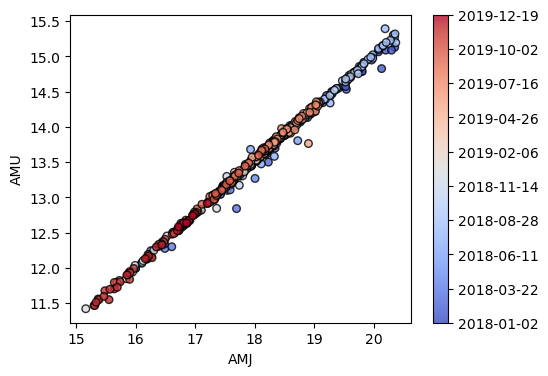

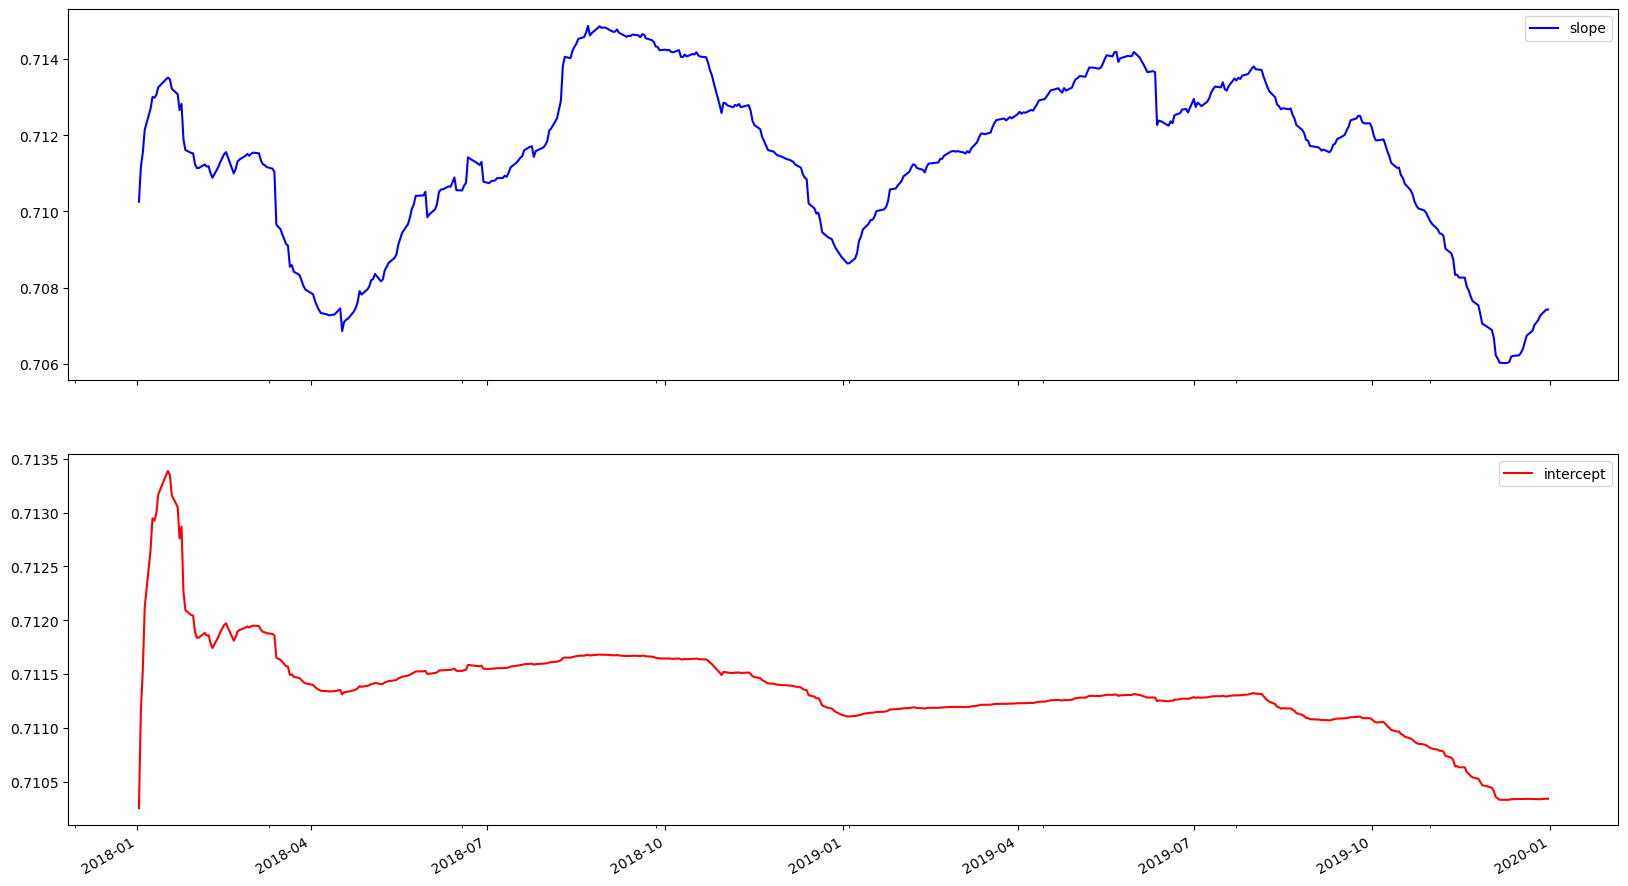

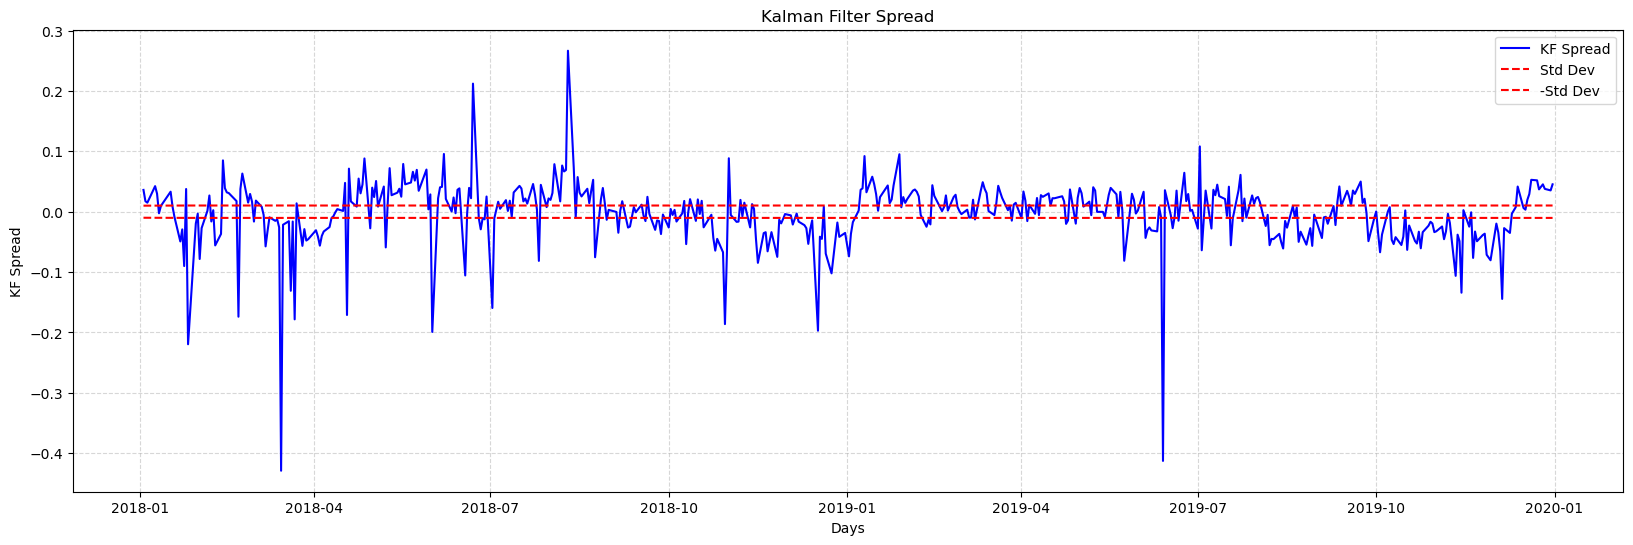

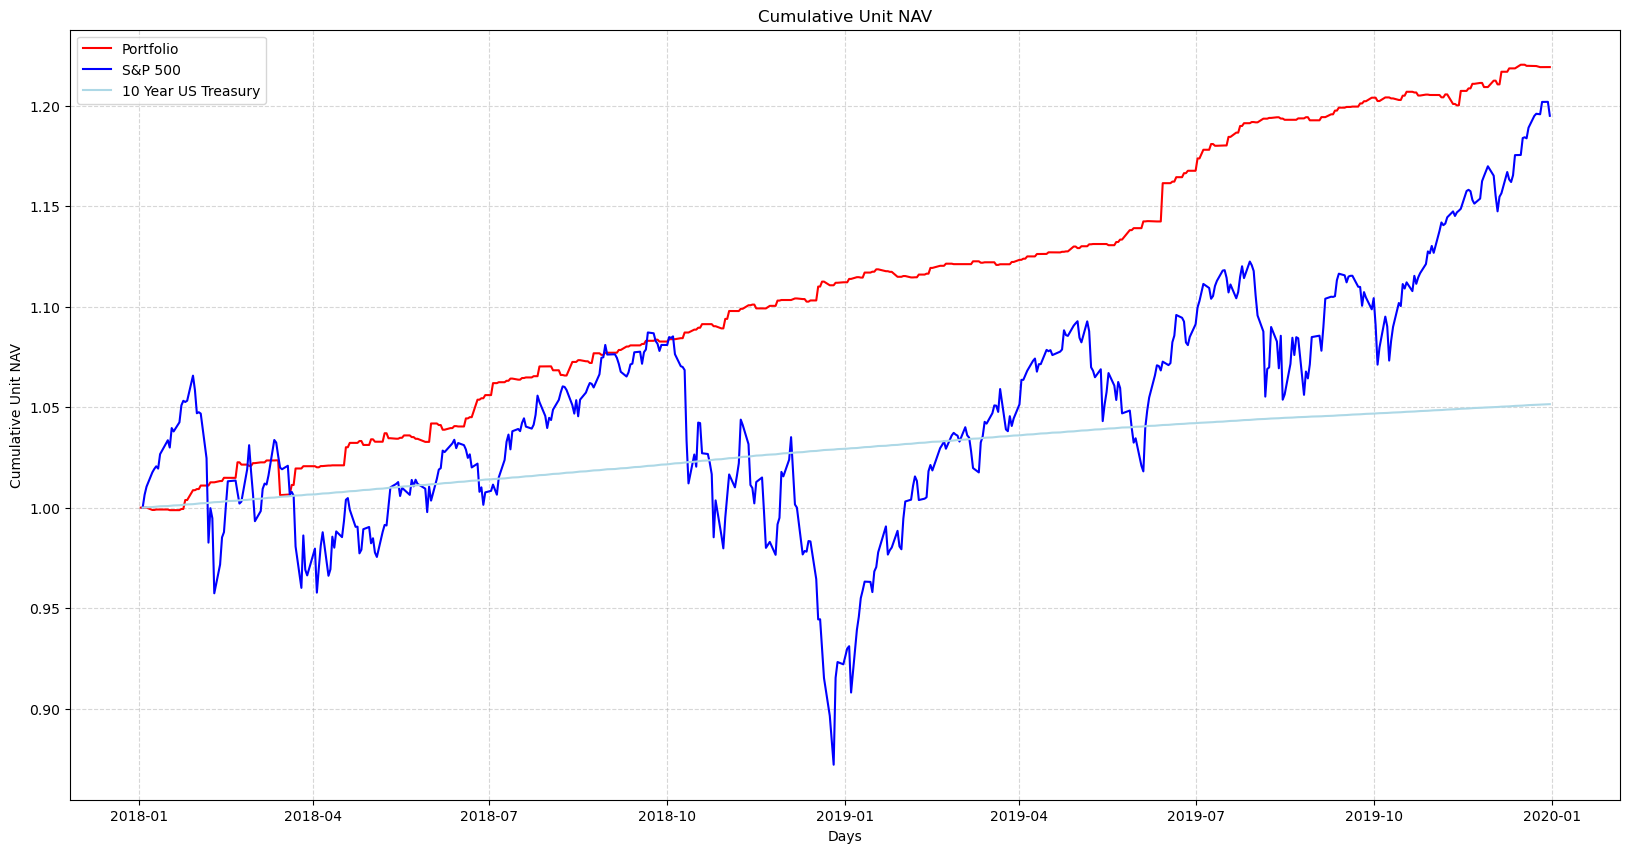

,KF Pairs Trading,S&P 500,10 Year US Treasury
Annualized Return,0.099877,0.100809,0.025256
Annualized Volatility,0.027572,0.149546,0.000311
Sharpe Ratio,2.897026,0.540360,nan
Max Drawdown,-0.016852,-0.197782,-0.000000


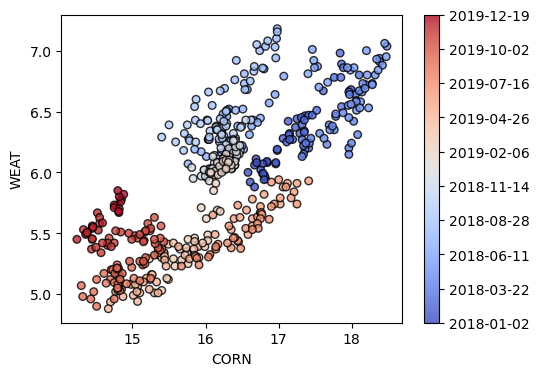

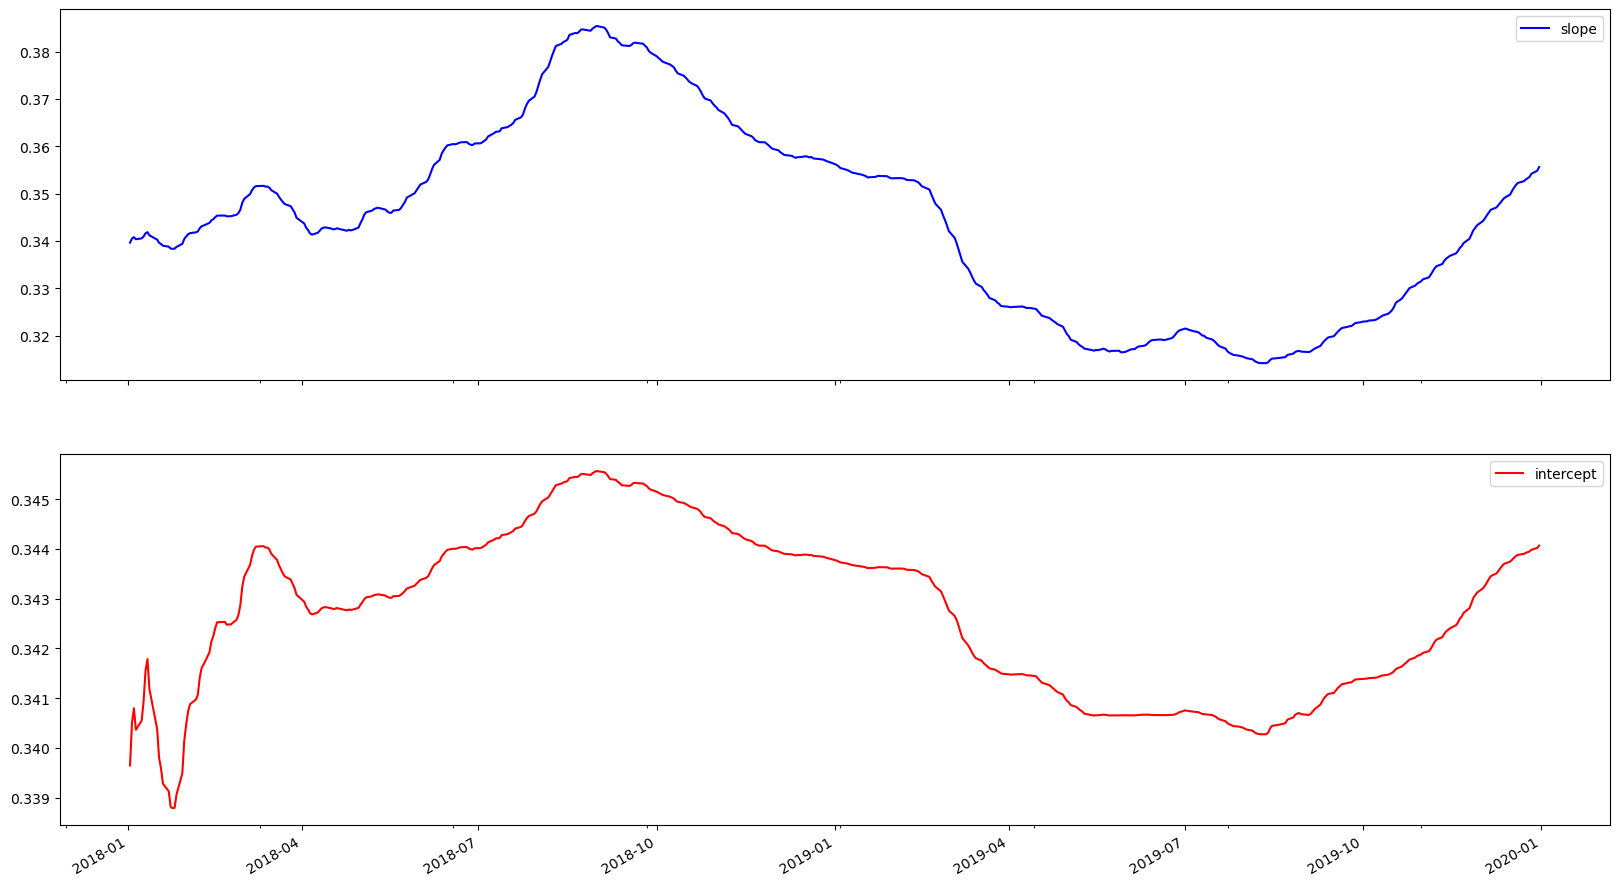

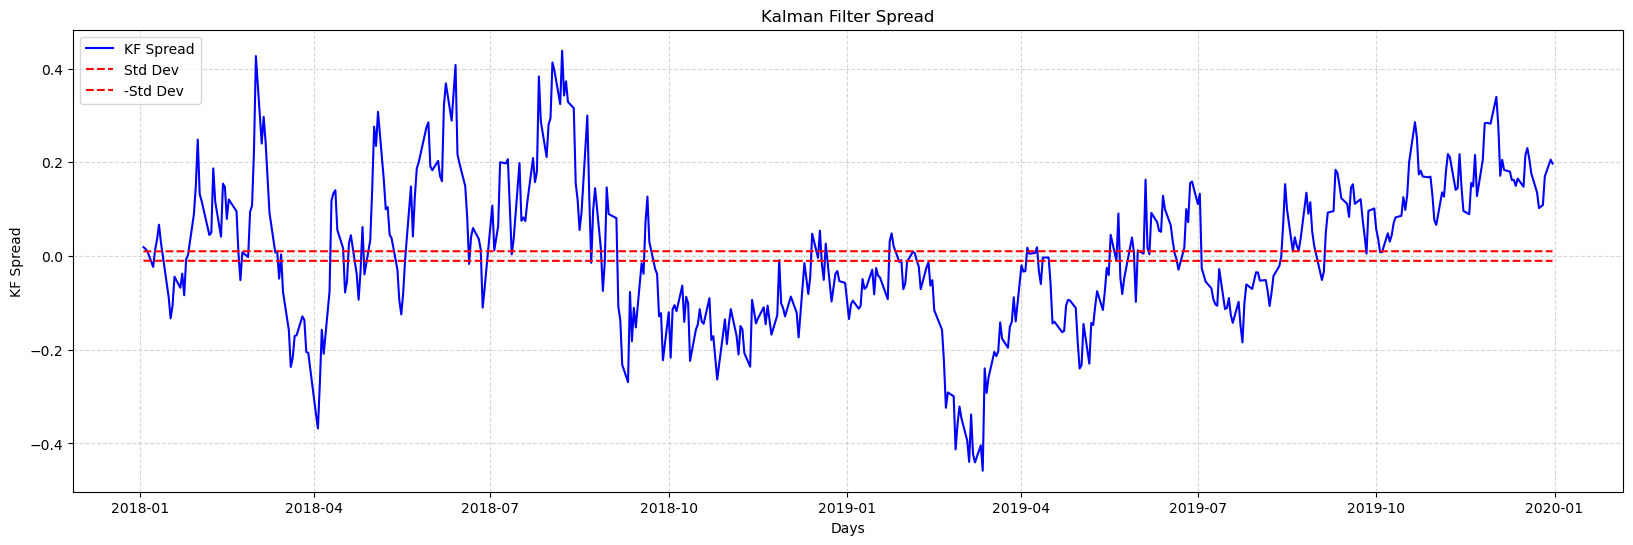

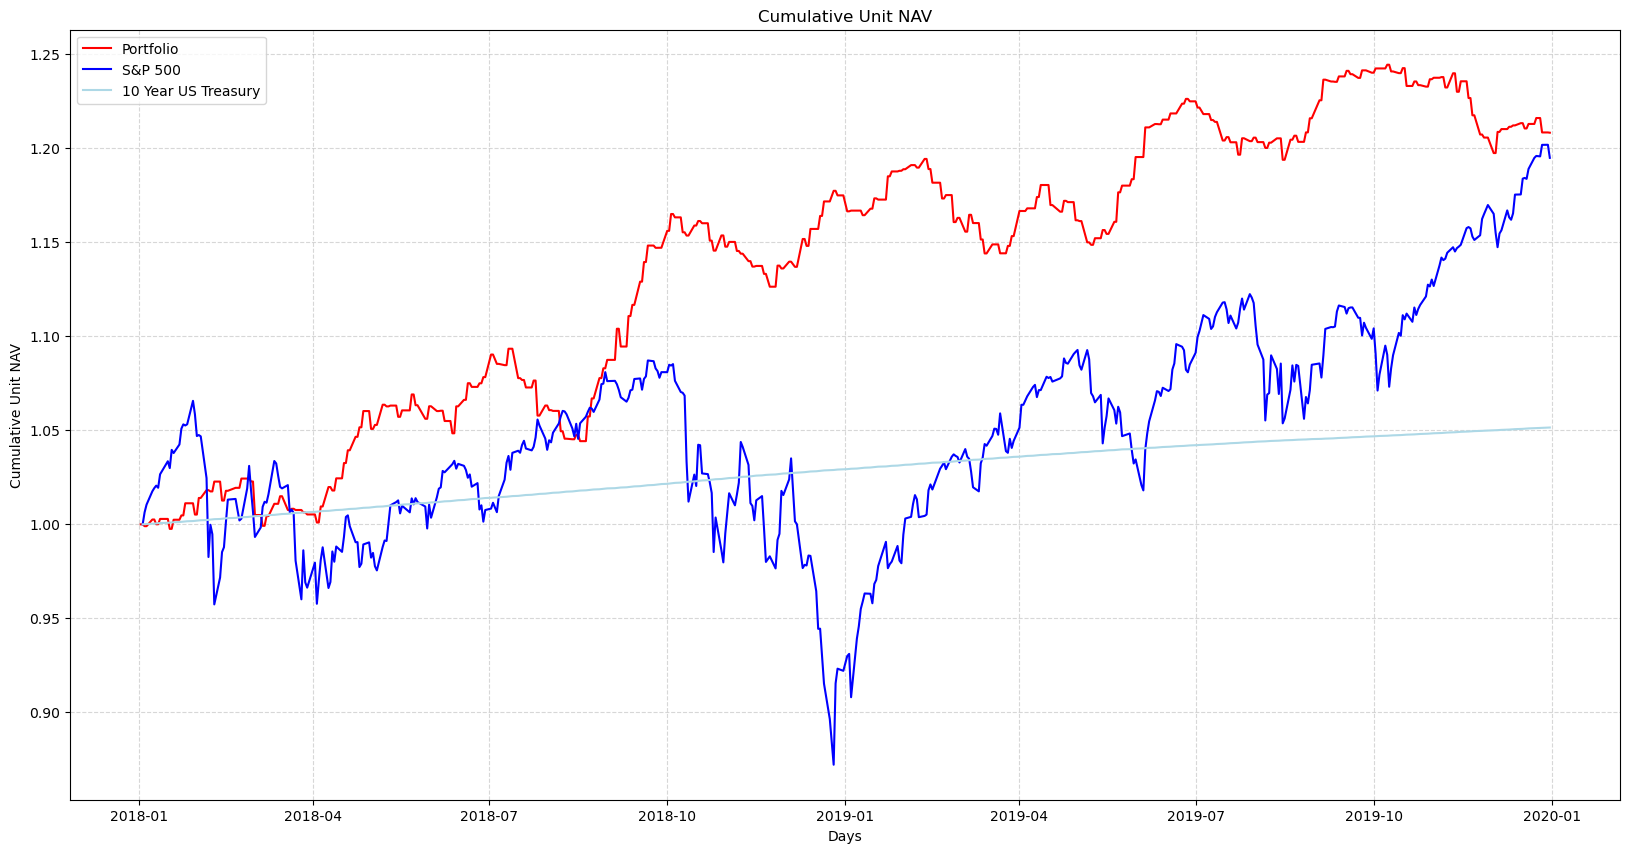

,KF Pairs Trading,S&P 500,10 Year US Treasury
Annualized Return,0.097040,0.100809,0.025256
Annualized Volatility,0.063921,0.149546,0.000311
Sharpe Ratio,1.205247,0.540360,nan
Max Drawdown,-0.044956,-0.197782,-0.000000


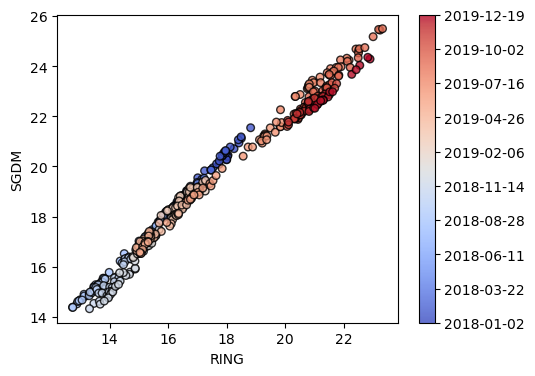

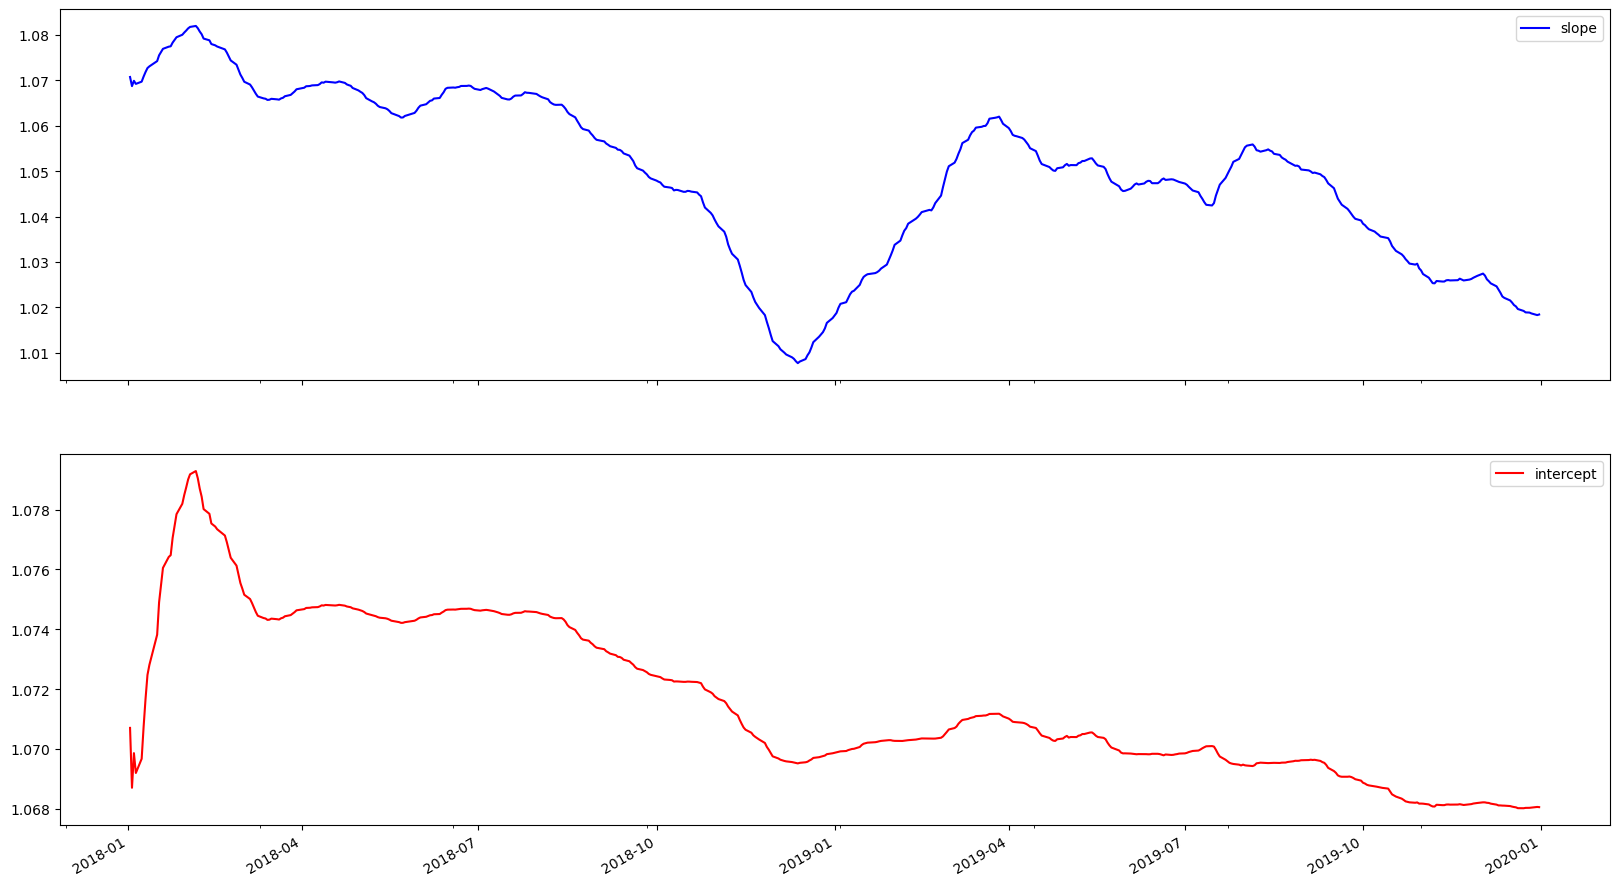

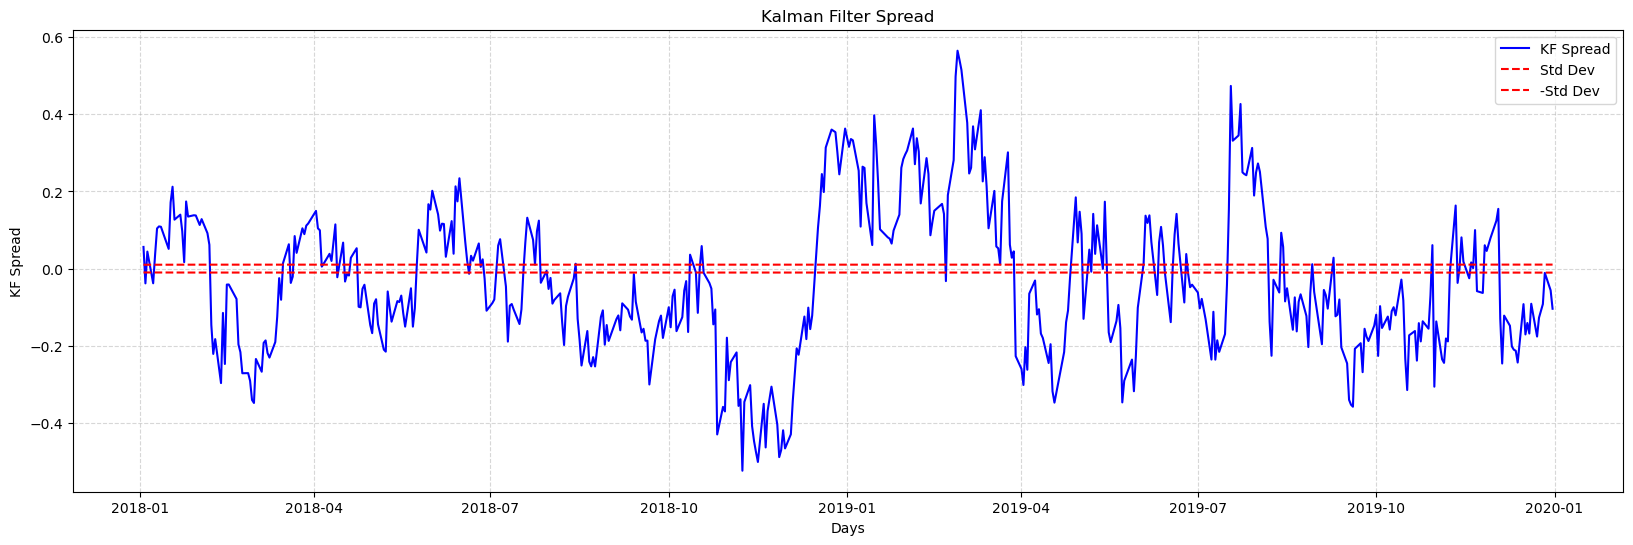

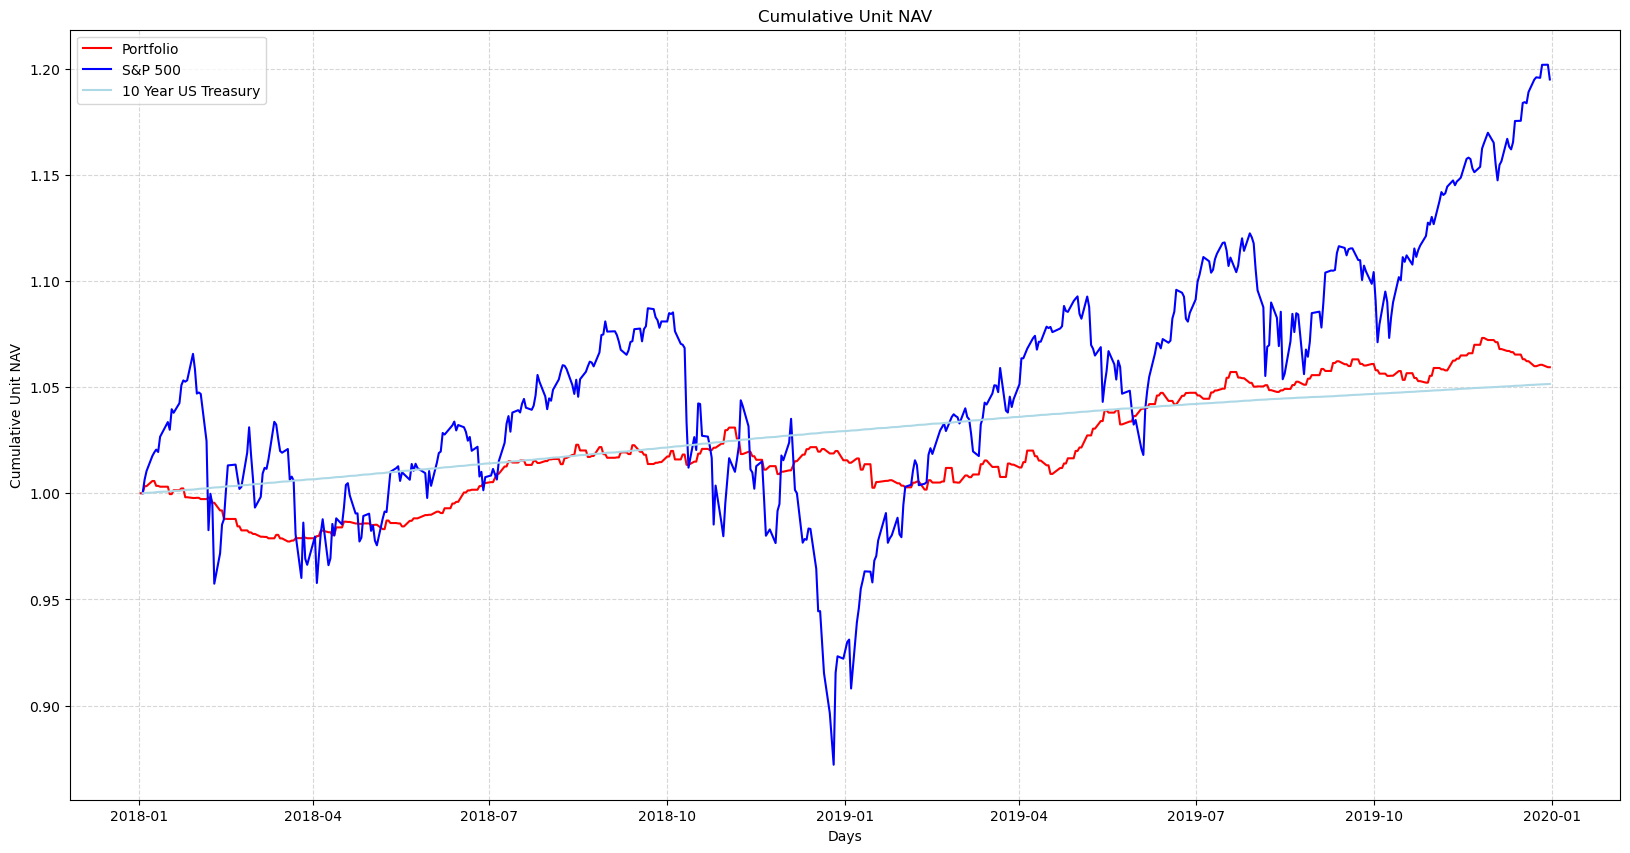

,KF Pairs Trading,S&P 500,10 Year US Treasury
Annualized Return,0.029381,0.100809,0.025256
Annualized Volatility,0.028932,0.149546,0.000311
Sharpe Ratio,0.324236,0.540360,nan
Max Drawdown,-0.028329,-0.197782,-0.000000


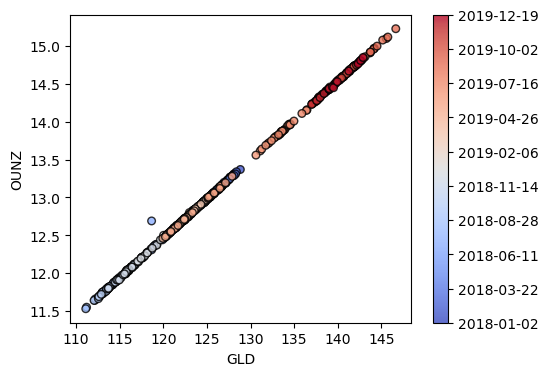

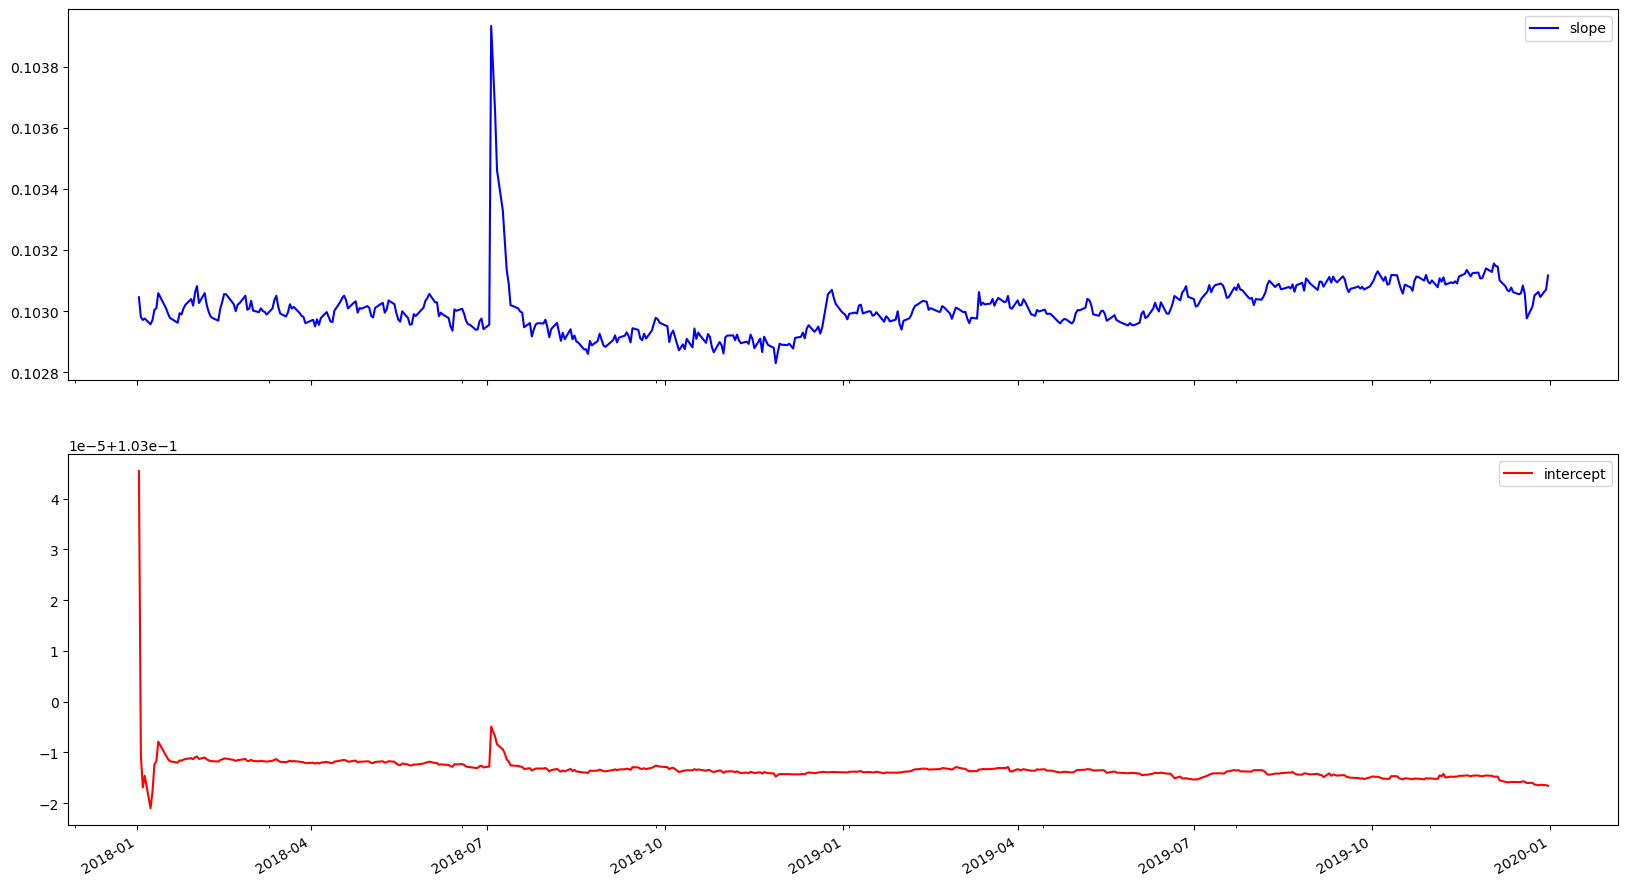

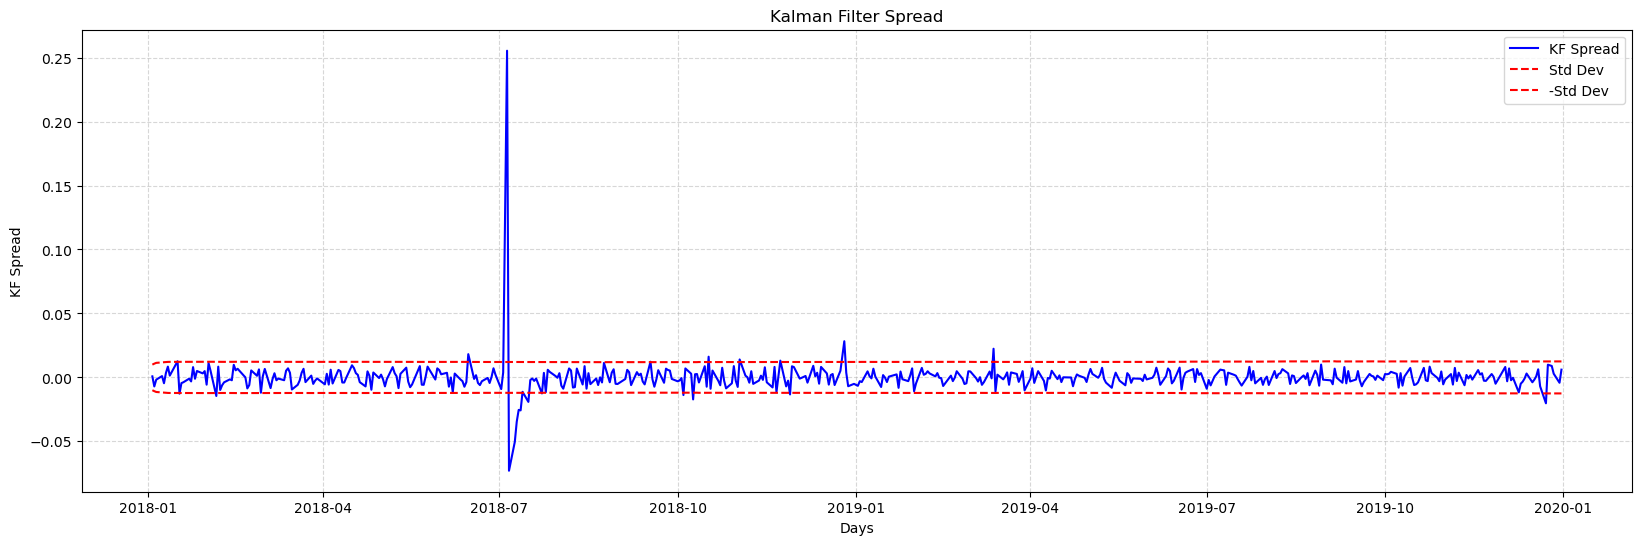

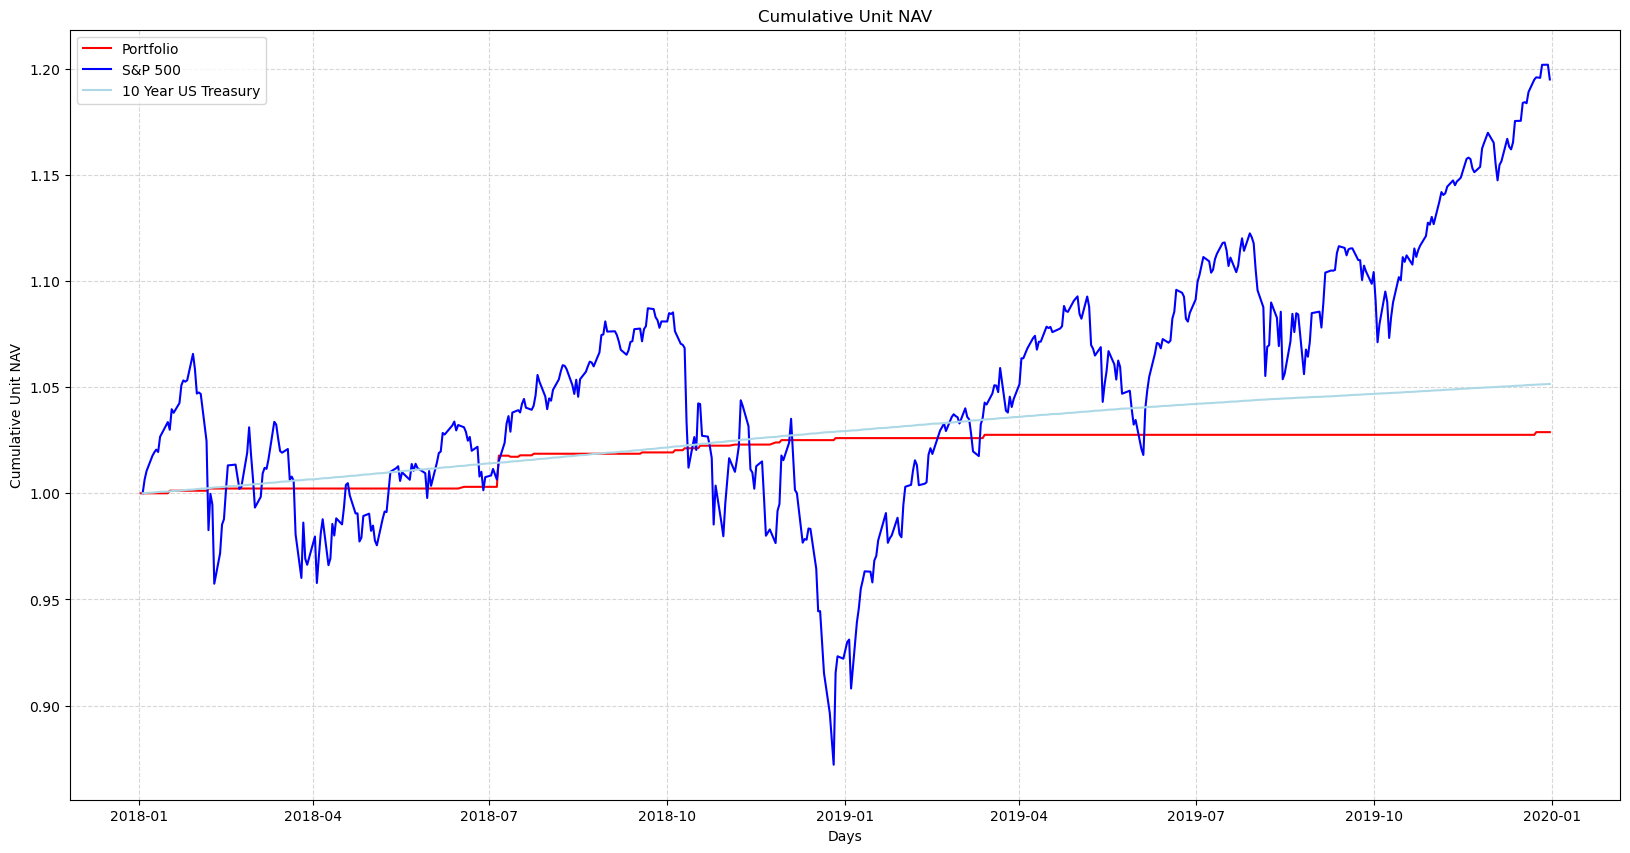

,KF Pairs Trading,S&P 500,10 Year US Treasury
Annualized Return,0.014309,0.100809,0.025256
Annualized Volatility,0.010684,0.149546,0.000311
Sharpe Ratio,-0.532690,0.540360,nan
Max Drawdown,-0.000493,-0.197782,-0.000000


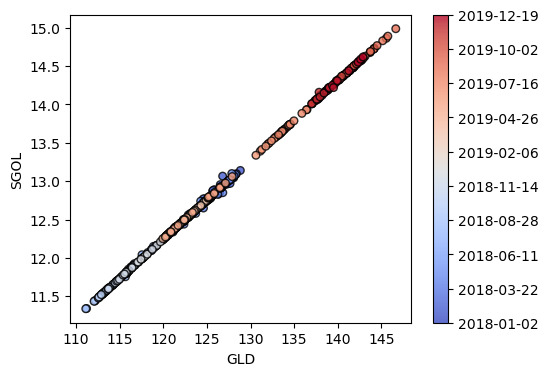

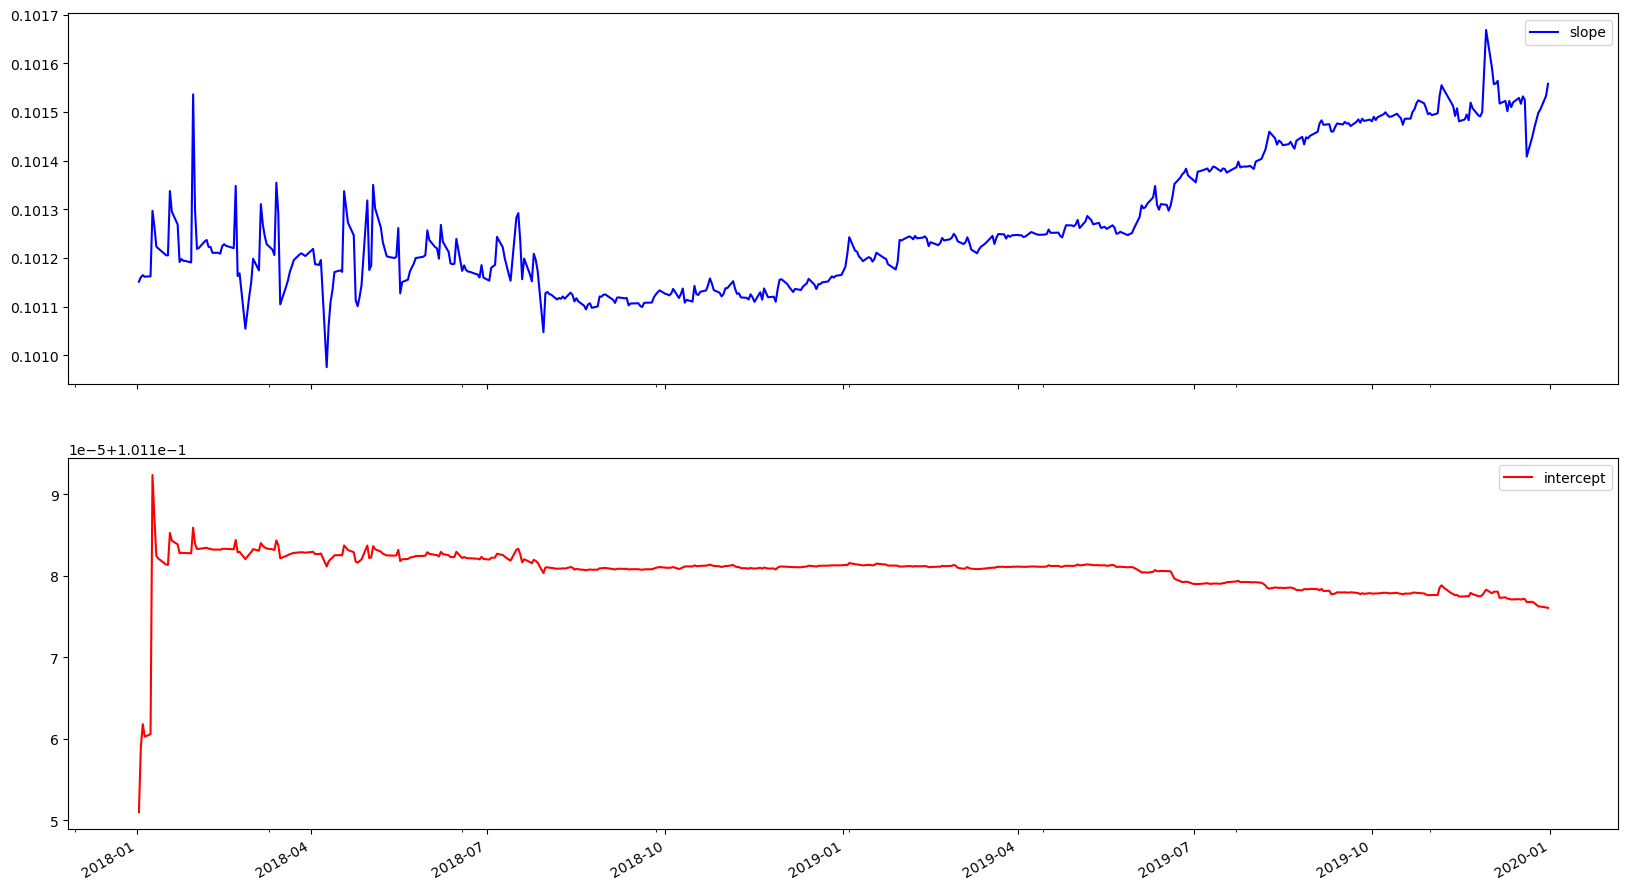

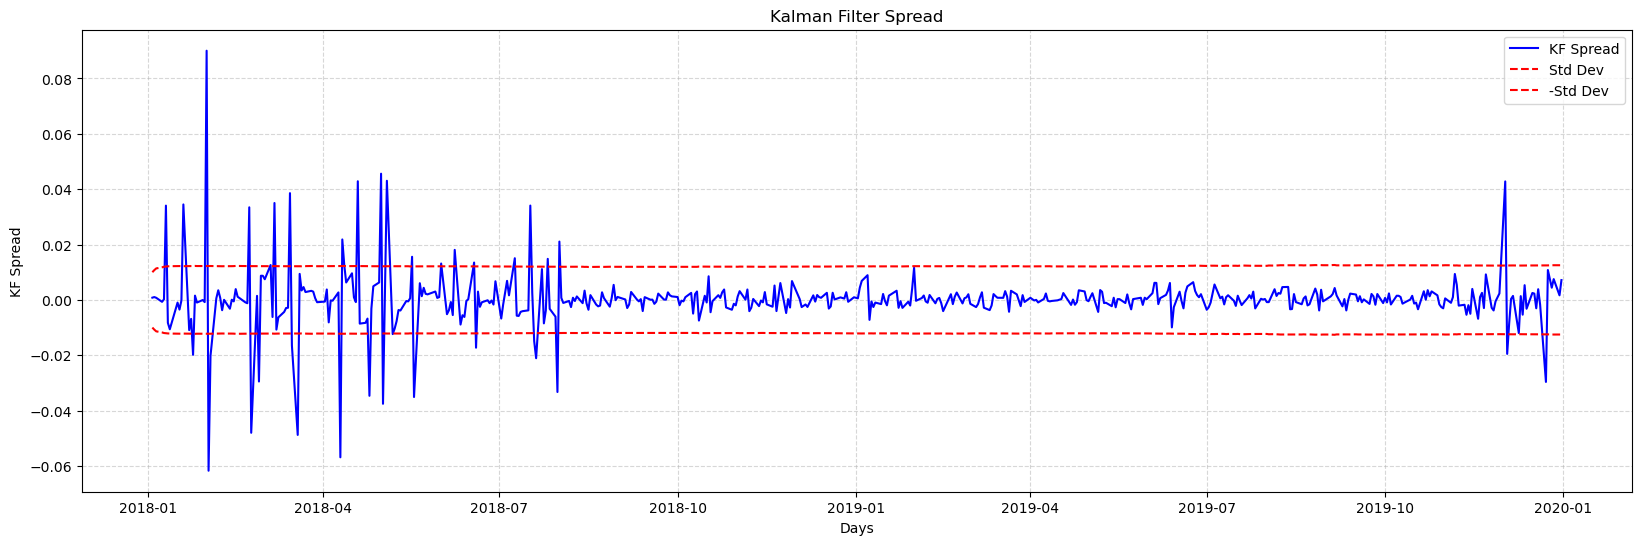

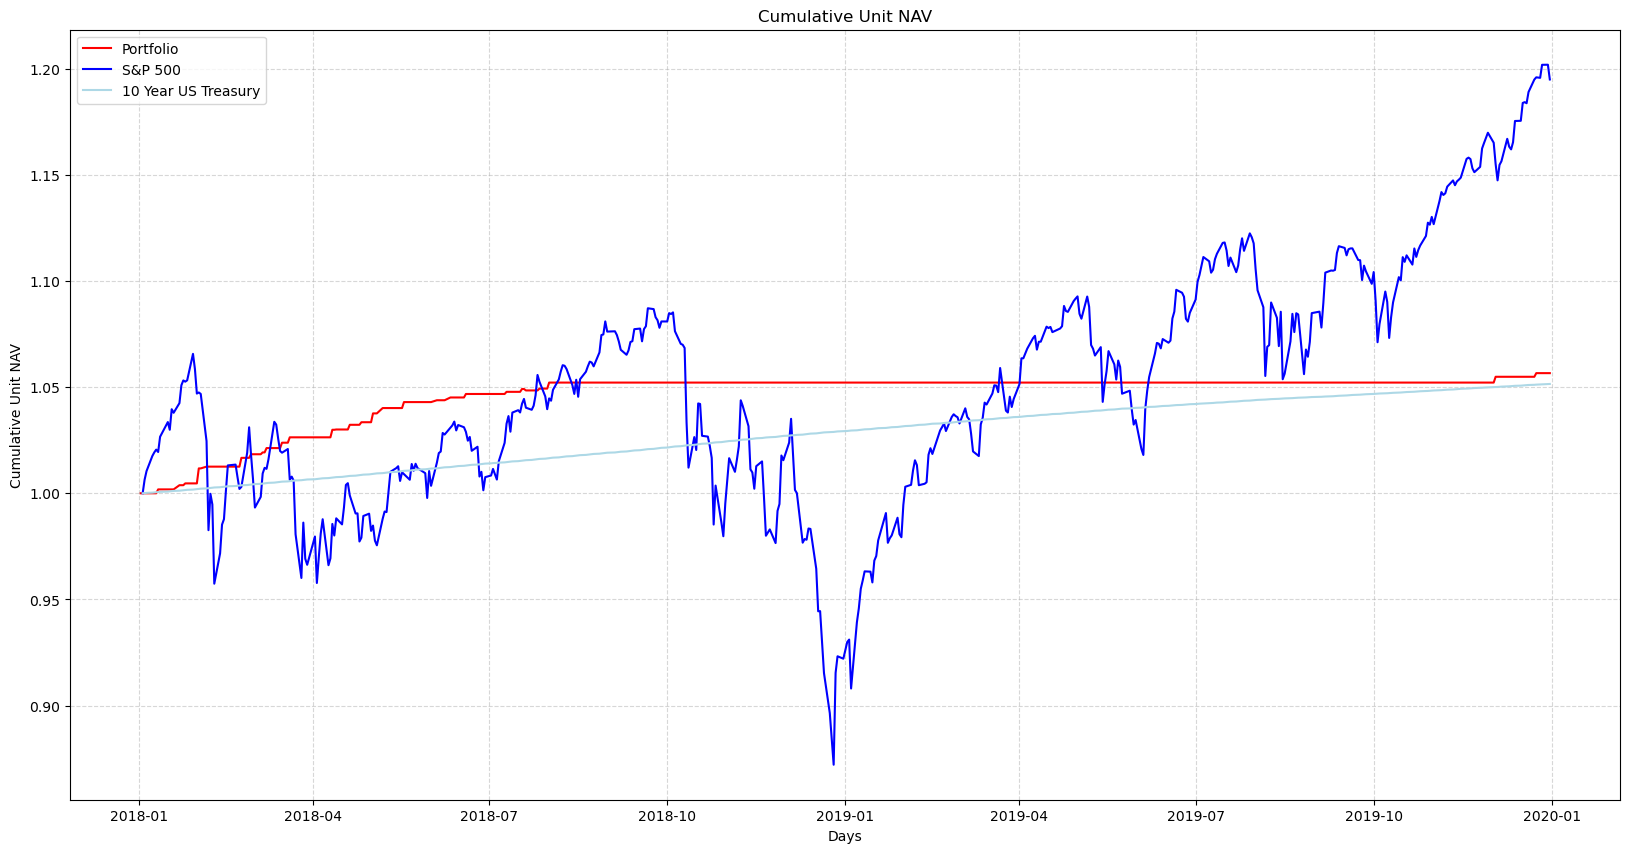

,KF Pairs Trading,S&P 500,10 Year US Treasury
Annualized Return,0.027675,0.100809,0.025256
Annualized Volatility,0.008990,0.149546,0.000311
Sharpe Ratio,0.853761,0.540360,nan
Max Drawdown,-0.000656,-0.197782,-0.000000


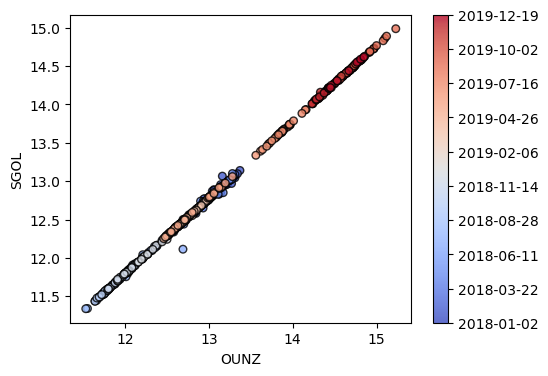

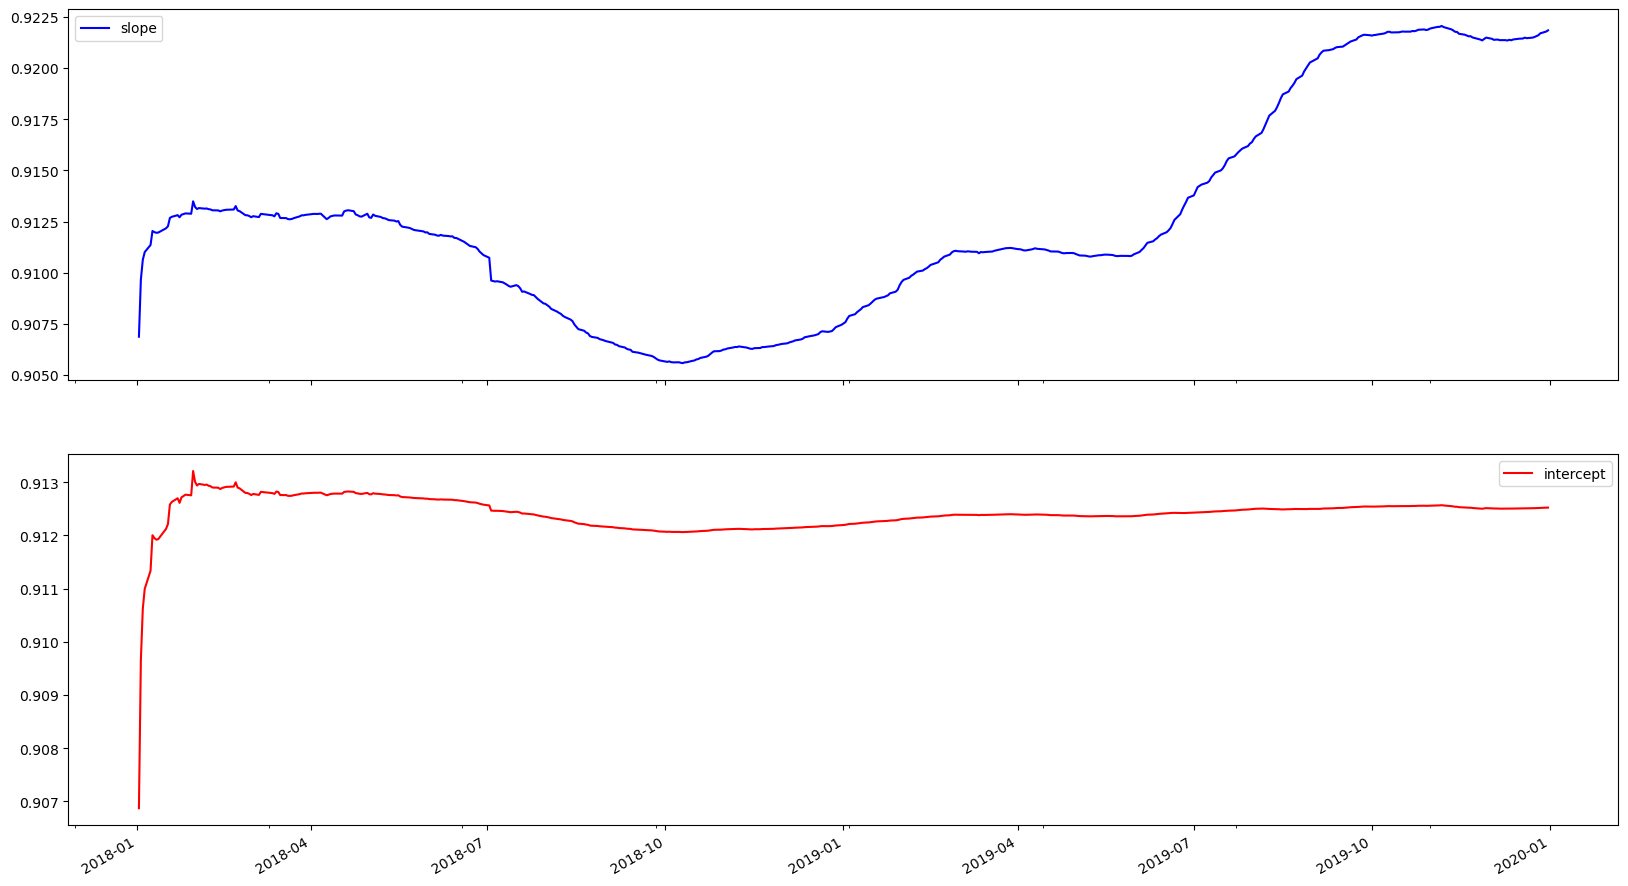

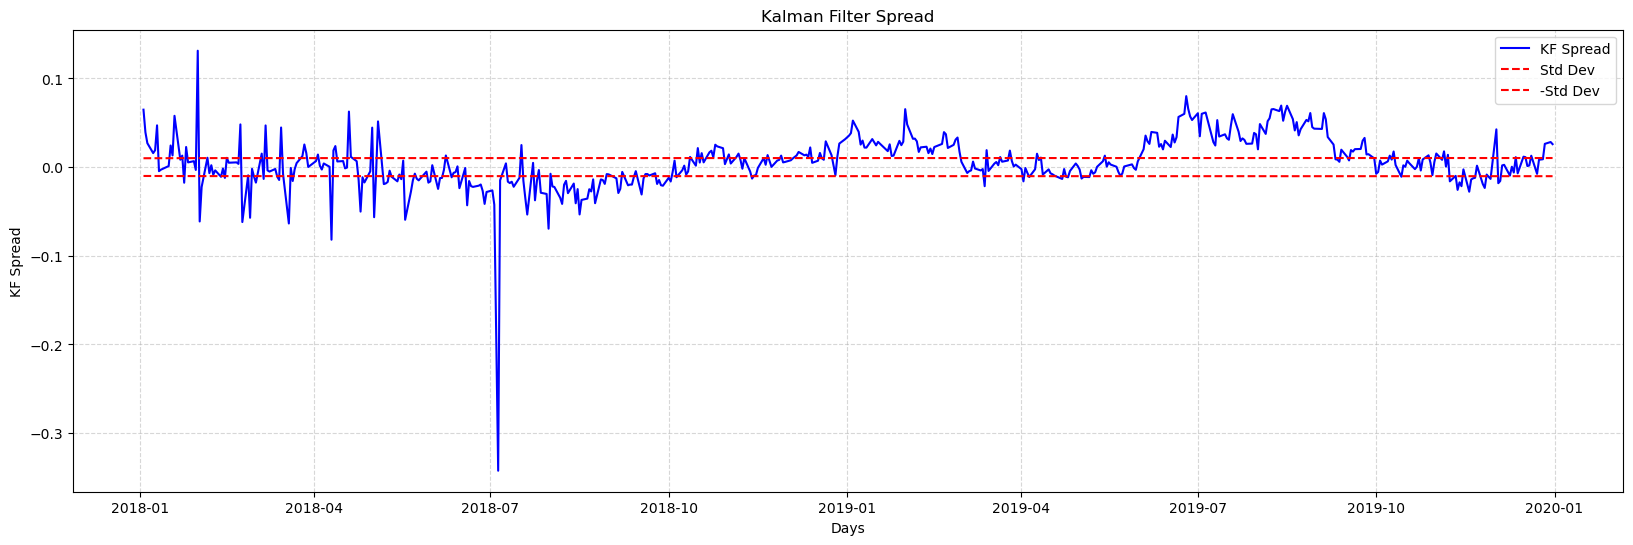

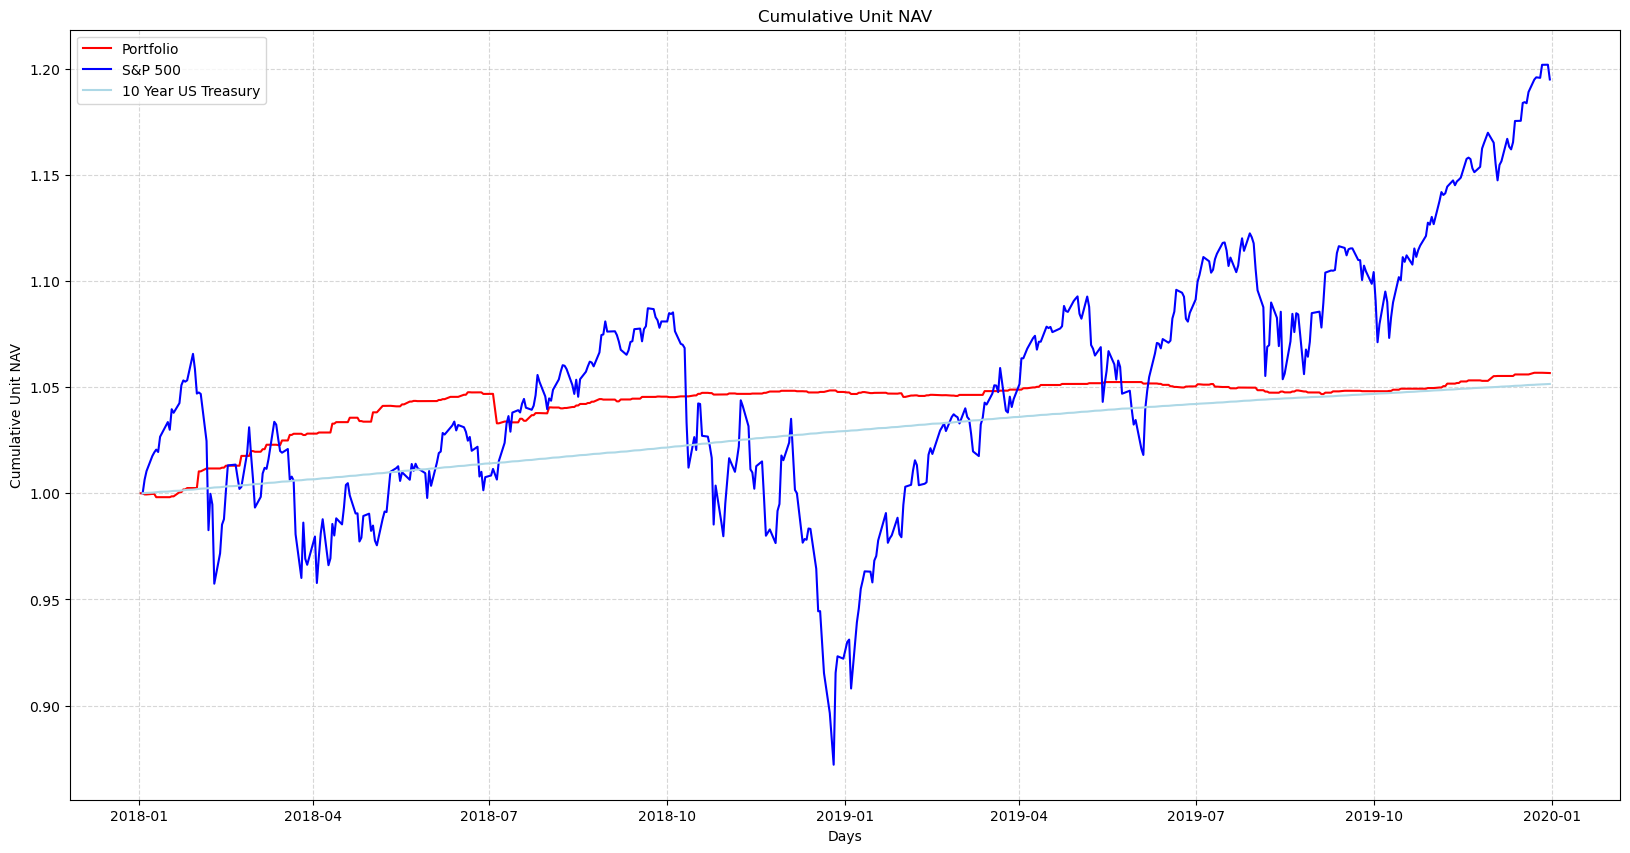

,KF Pairs Trading,S&P 500,10 Year US Treasury
Annualized Return,0.027757,0.100809,0.025256
Annualized Volatility,0.014143,0.149546,0.000311
Sharpe Ratio,0.548491,0.540360,nan
Max Drawdown,-0.013971,-0.197782,-0.000000


In [26]:
etfs_list = [ ('AMJ', 'AMU'), ('CORN', 'WEAT'), ('RING', 'SGDM'), ('GLD', 'OUNZ'), ('GLD', 'SGOL'), ('OUNZ', 'SGOL')]
# etfs_list = [ ('AMJ', 'CORN'), ('AMU', 'WEAT'), ('RING', 'GLD'), ('SGDM', 'CORN'), ('AMJ', 'OUNZ'), ('CORN', 'SGOL')]
pnl_dict = {}
nav_dict = {}
drawdowns_dict = {}
k = 0.01


for etfs in etfs_list:
    print("\n")
    display(HTML(f'<p style="font-size: 30px;">{etfs}</p>'))
    print("\n")
    draw_date_coloured_scatterplot(etfs, prices)
    state_means, state_covs = calc_slope_intercept_kalman(etfs, prices)
    draw_slope_intercept_changes(prices, state_means)
    
    # Run the backtest
    context = Context()
    initialize(context, etfs, prices)
#     context.state_means, context.state_covs = calc_slope_intercept_kalman(etfs, prices)
#     context.tickers = etfs
    
    ### DEBUG
    context.etf1_price_prev = df_prices_test[etfs[0]].iloc[0]
    context.etf2_price_prev = df_prices_test[etfs[1]].iloc[0]
    
#     print("etf1_price_prev: ", context.etf1_price_prev)
#     print("etf2_price_prev: ", context.etf2_price_prev)
    
    for i in range(len(df_prices_test) - 1):
        handle_data(context, prices.iloc[: i+1], etfs, k)
    
    # forecast error
    errors = context.errors
    
    # forecast standard deviation
    stds = context.stds
    neg_stds = [-x for x in stds]
    
    # pnl
    pnl = context.pnl_history
    pnl_dict[etfs] = pnl
    
    # NAV
    nav = context.nav_history
    nav_dict[etfs] = nav
    
    # daily returns
    daily_returns = context.daily_returns
    
    # cumulative returns
    cum_returns = np.cumprod(1 + np.array(context.daily_returns)) - 1
    
    #drawdown
    ### DEBUG
    highwatermarks = np.maximum.accumulate(nav)
    drawdowns = (nav - highwatermarks) / highwatermarks
    drawdowns_dict[etfs] = drawdowns
    
    # plot figures
    plot_spread(prices, errors, stds, neg_stds)
    plot_nav_sp500(prices, nav, sp500_nav, USTreasury_nav)
#     plot_cum_returns(prices, cum_returns)
#     plot_drawdown(prices, drawdowns)
    display(HTML(pnl_metrics(daily_returns, sp500_nav, sp500_drawdowns, USTreasury_nav, USTreasury_drawdowns).style.set_table_attributes('style="font-size: 16px;"').render()))
    print('\n\n\n')
    

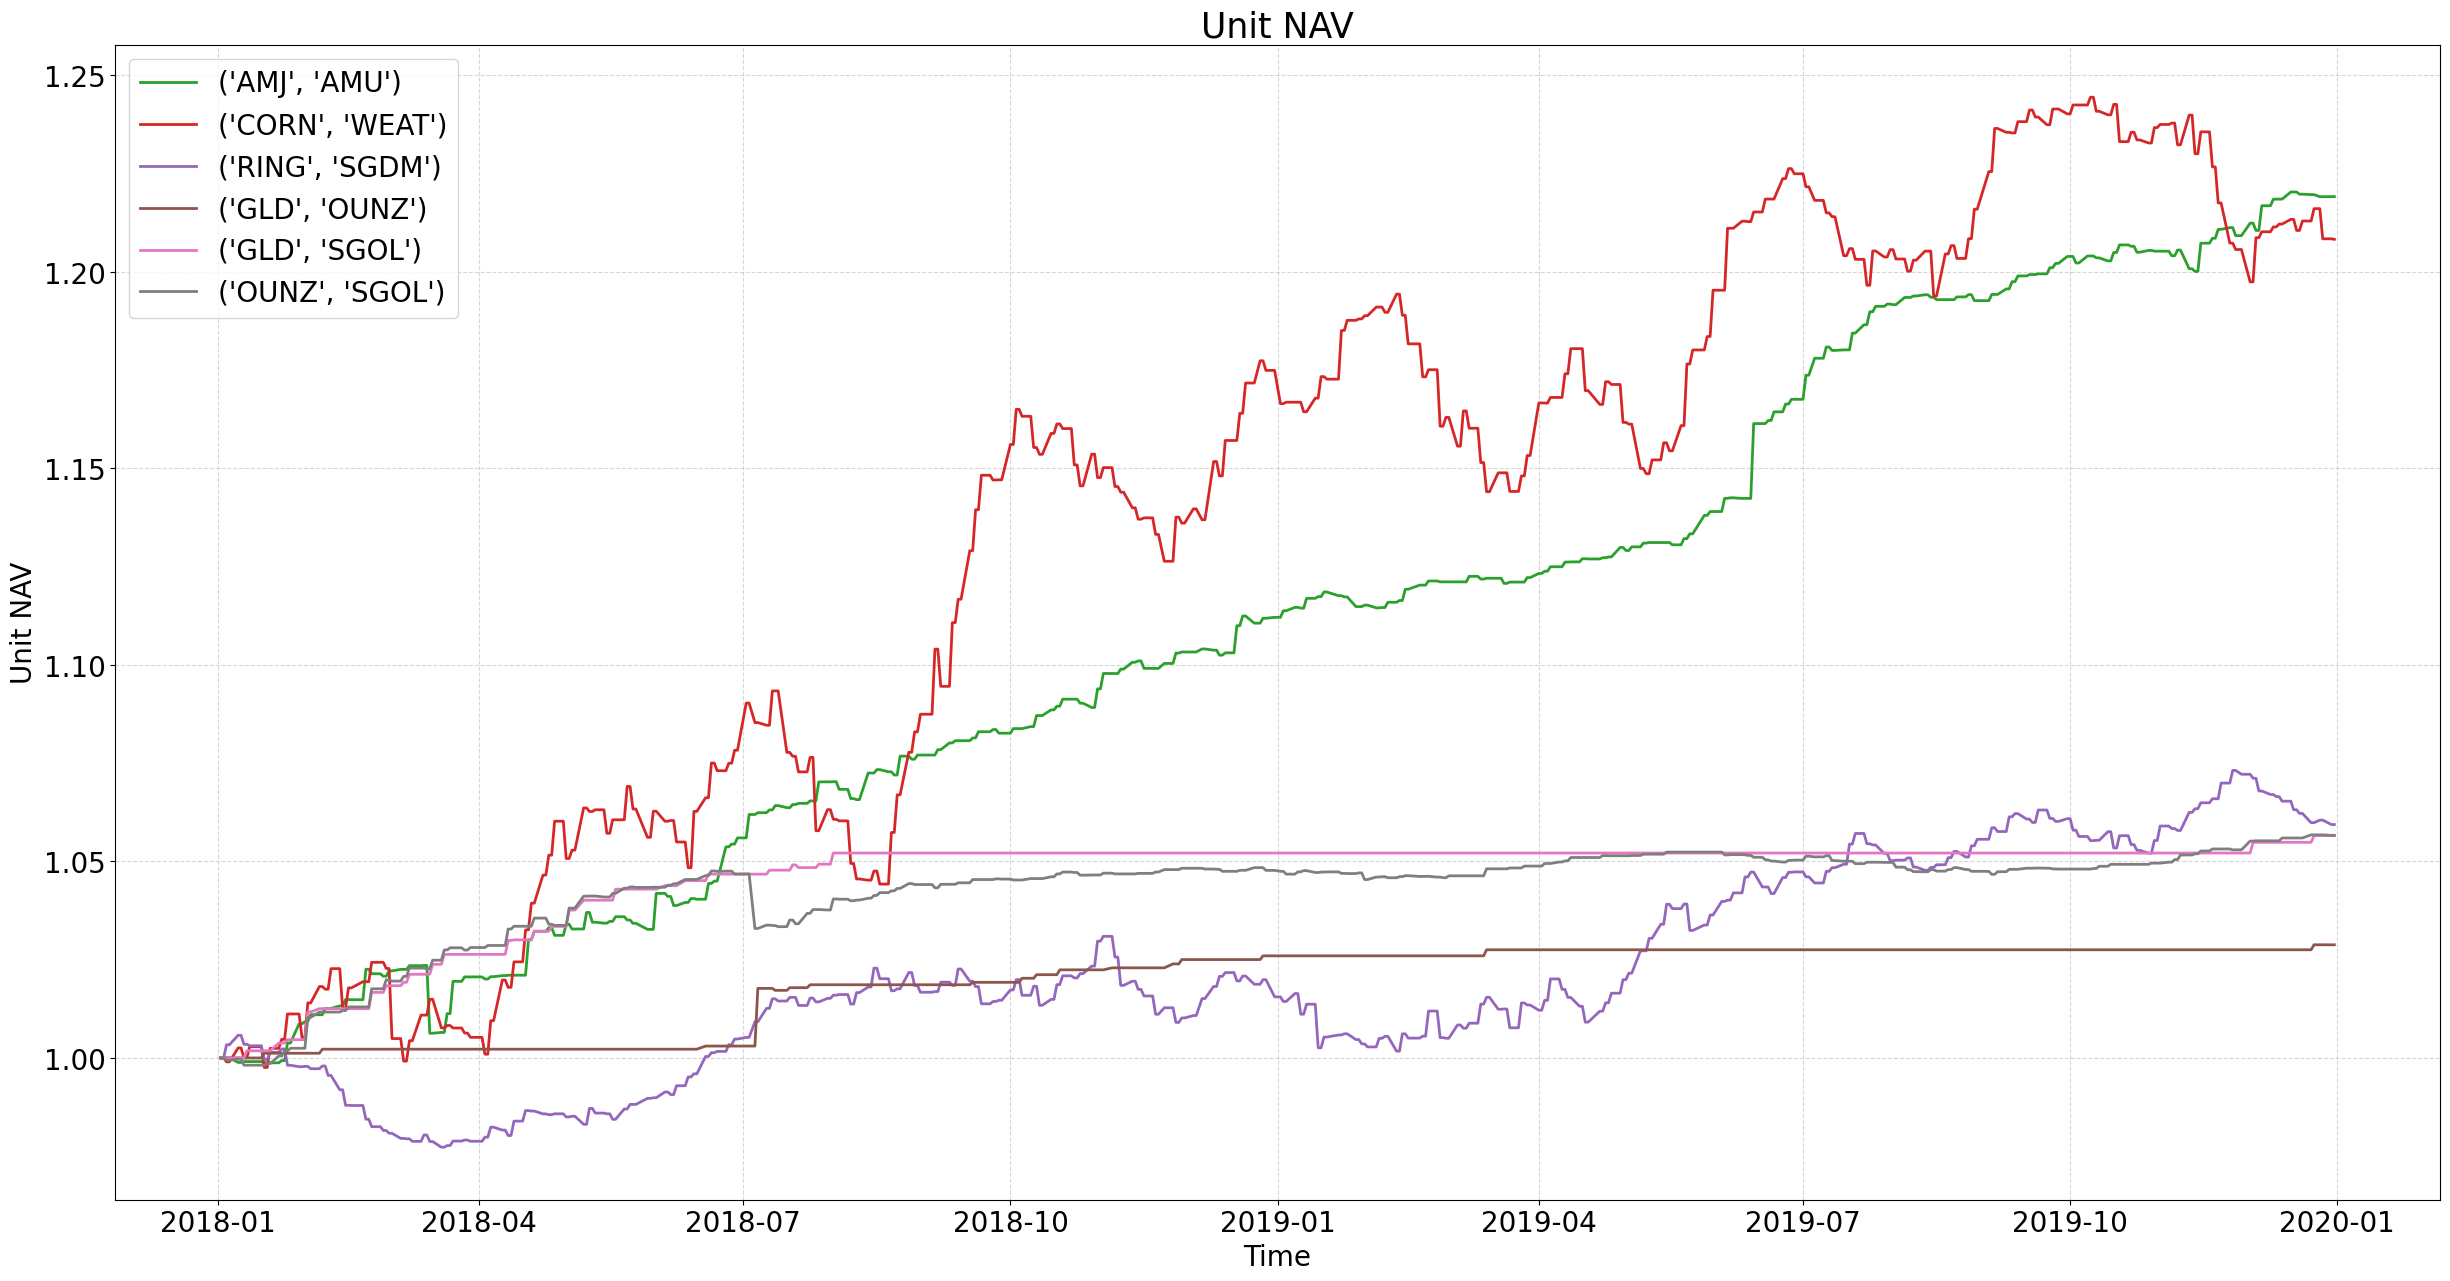

In [27]:
fig, ax = plt.subplots(figsize=(30, 15))
colors = [ '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e']

for idx, (key, value) in enumerate(nav_dict.items()):
    ax.plot(prices.index, value, label=key, color=colors[idx % len(colors)], linestyle='-', linewidth=2)
ax.set_title('Unit NAV', fontsize=25)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Unit NAV', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=20, loc='best')
plt.show()


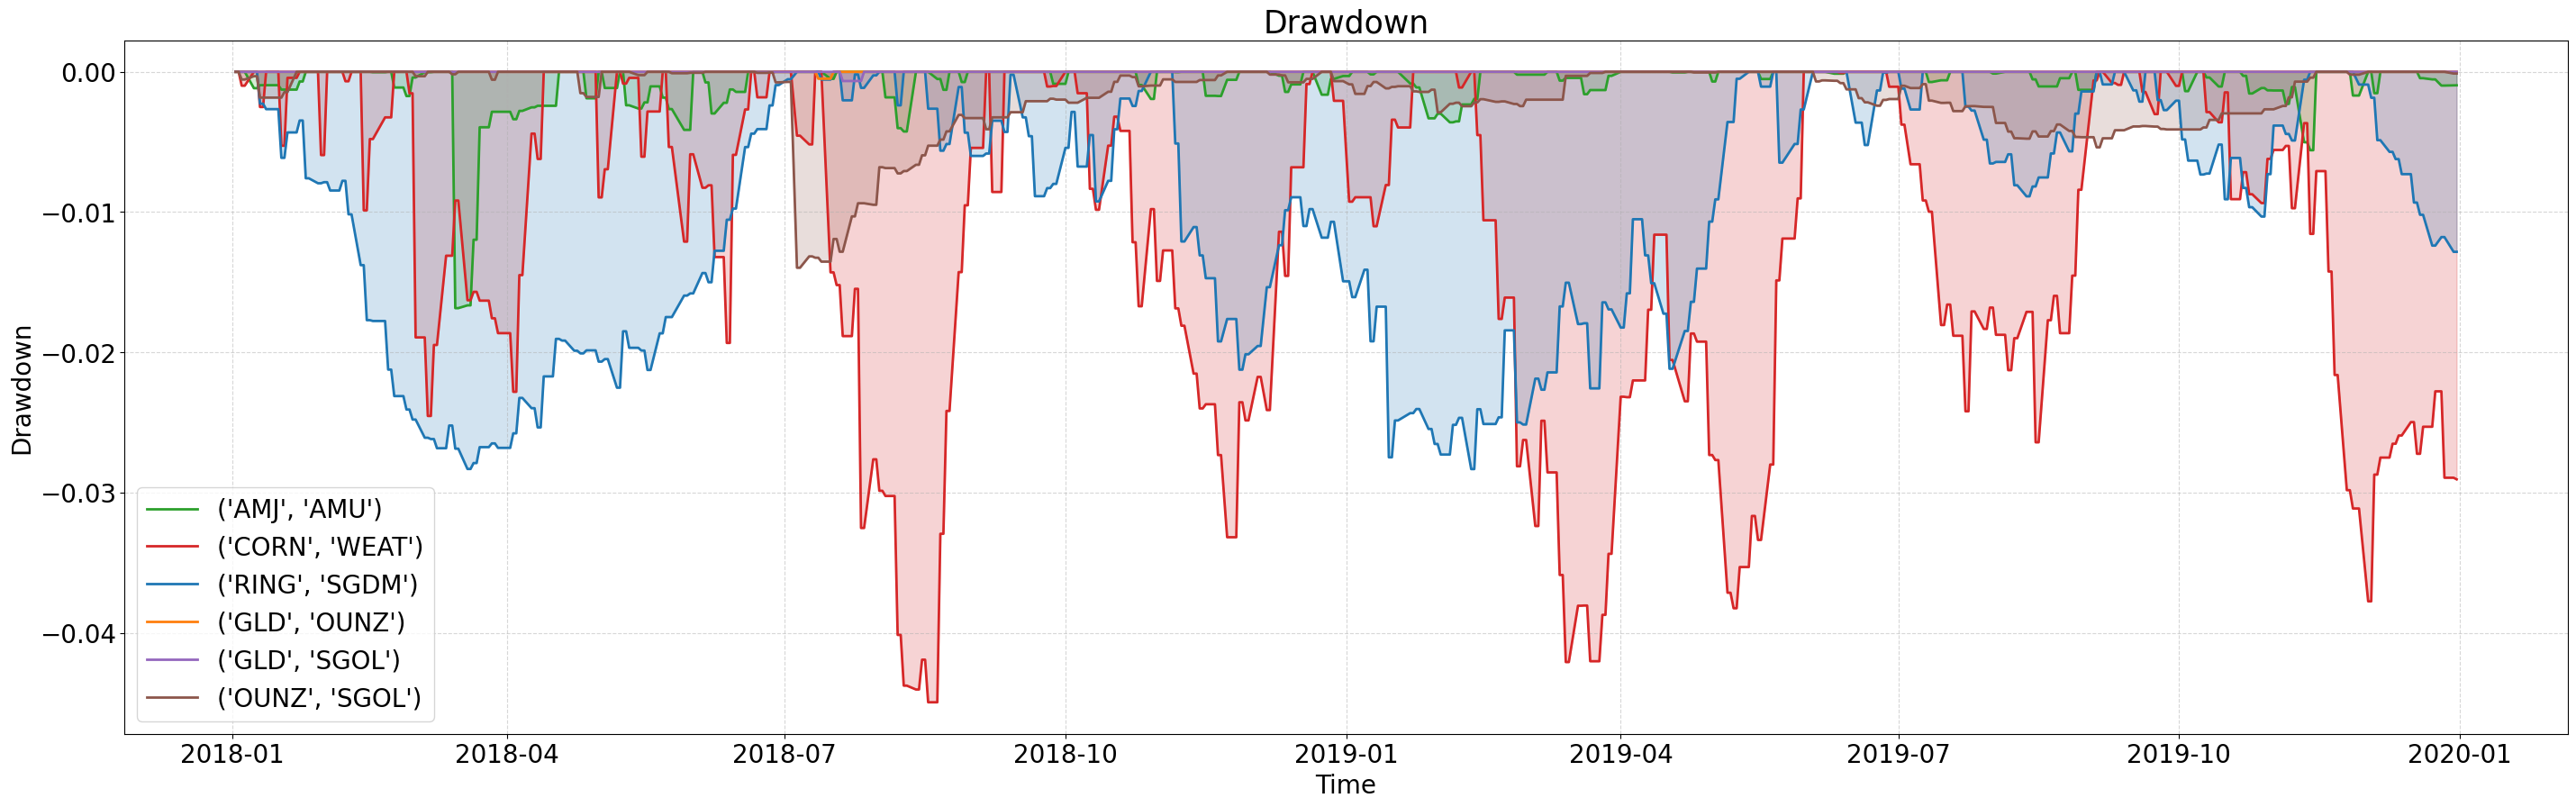

In [28]:
fig, ax = plt.subplots(figsize=(35, 10))
colors = ['#2ca02c', '#d62728','#1f77b4', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for idx, (key, value) in enumerate(drawdowns_dict.items()):
    ax.plot(prices.index, value, label=key, color=colors[idx % len(colors)], linestyle='-', linewidth=2)
    ax.fill_between(prices.index, value, 0, color=colors[idx % len(colors)], alpha=0.2)
ax.set_title('Drawdown', fontsize=25)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Drawdown', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=20, loc='best')
plt.show()

# Build a equal-weight portfolio

In [29]:
portfolio_nav = [0] * len(next(iter(nav_dict.values())))

# portfolio NAV
num_assets = len(nav_dict)
for key, nav_list in nav_dict.items():
    for i, nav in enumerate(nav_list):
        portfolio_nav[i] += nav / num_assets

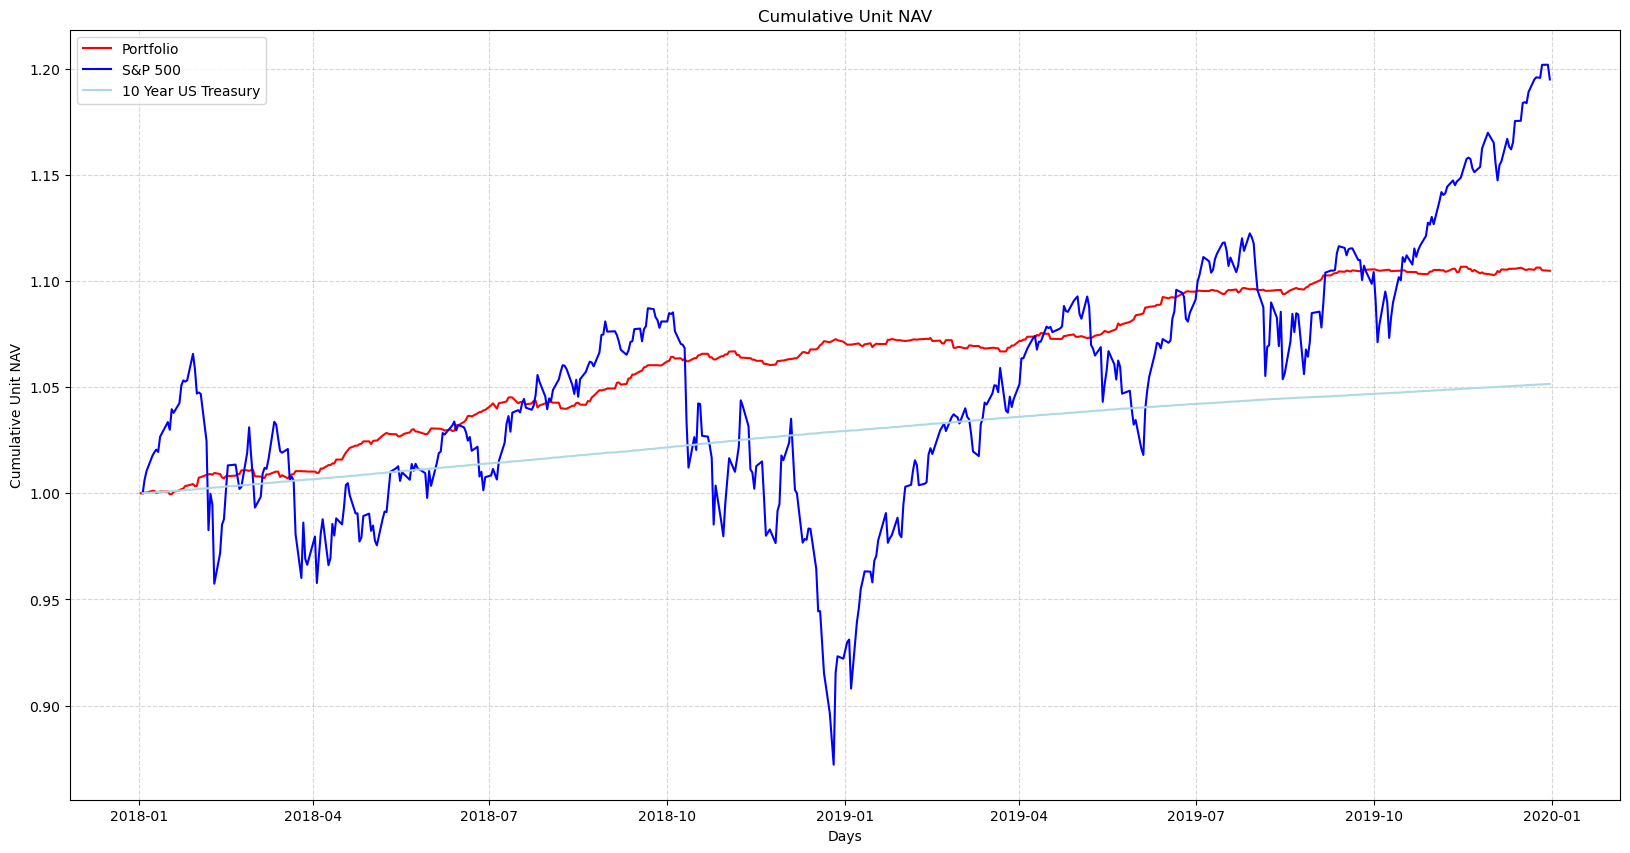

In [30]:
plot_nav_sp500(prices, portfolio_nav, sp500_nav, USTreasury_nav)

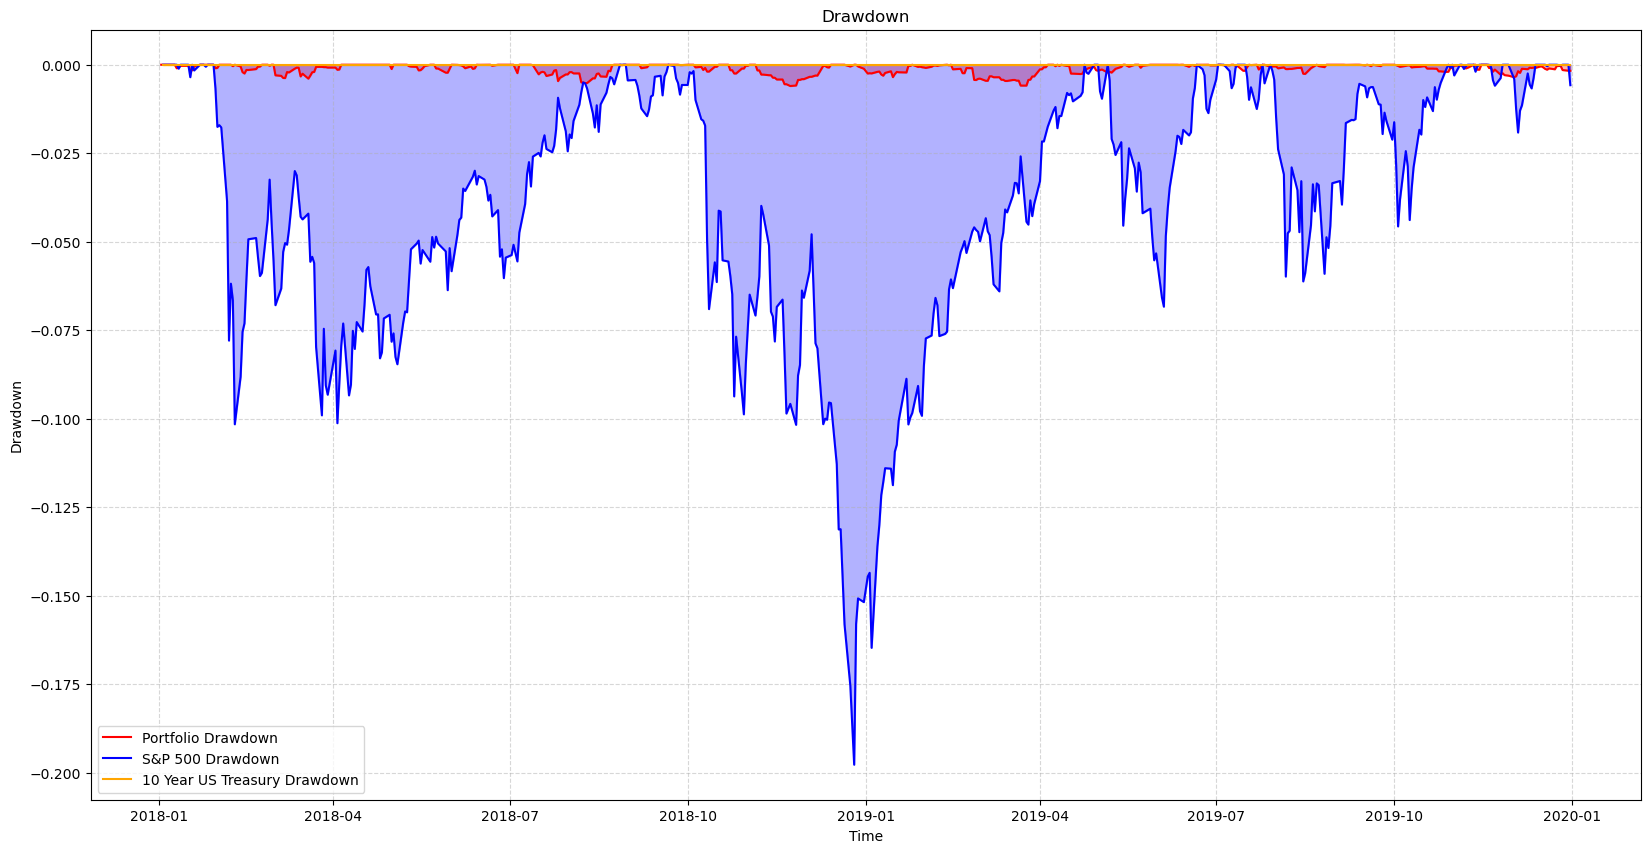

In [31]:
#drawdown
portfolio_drawdown = calculate_drawdown(portfolio_nav)
plot_drawdown_sp500(prices, portfolio_drawdown, sp500_drawdowns,USTreasury_drawdowns)

In [32]:
portfolio_daily_returns = calculate_daily_returns(portfolio_nav)
display(HTML(pnl_metrics(portfolio_daily_returns, sp500_nav, sp500_drawdowns, USTreasury_nav, USTreasury_drawdowns).style.set_table_attributes('style="font-size: 16px;"').render()))


,KF Pairs Trading,S&P 500,10 Year US Treasury
Annualized Return,0.050134,0.100809,0.025256
Annualized Volatility,0.013618,0.149546,0.000311
Sharpe Ratio,2.212841,0.540360,nan
Max Drawdown,-0.006020,-0.197782,-0.000000
